In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
from matplotlib import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_validate;
from sklearn.linear_model import LinearRegression, Ridge;
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score;

In [2]:
prod_p1 = pd.read_csv('Plant_1_Generation_Data.csv')
prod_p2 = pd.read_csv('Plant_2_Generation_Data.csv')
p1ws = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
p2ws = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Cleaning prod_p1

In [3]:
prod_p1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


- Data is very clean without Null values, negatives or infinites.
- The DATE_TIME column is in text format and will be converted to Timestamp.
- DC_POWER and AC_POWER seems to have a scale problem since DC_POWER should be very similar to AC_POWER but appears to be 10 times bigger instead.
- PLANT_ID column holds a single value throughout the entire dataset, this column will be deleted and the value stored in an external variable to reduce the Data Frame memory footprint.

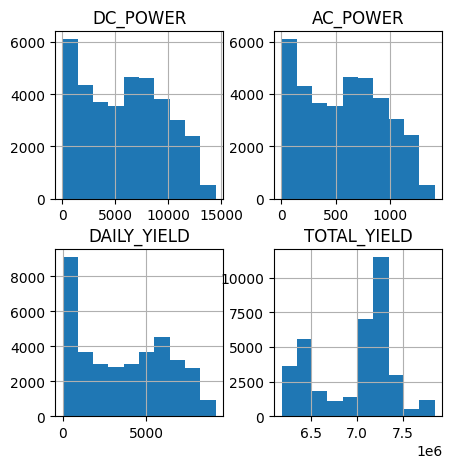

In [4]:
# Histogram of all non zero values
sample_df = prod_p1.loc[:, prod_p1.columns != 'PLANT_ID']
sample_df = sample_df[(prod_p1['DAILY_YIELD'] > 0) & (prod_p1['AC_POWER'] > 0)]
sample_df.hist(figsize=(5,5))
plt.show()

In [5]:
def clean(df):
    if 'TOTAL_YIELD' not in df.columns:
        raise ValueError('Cleaned')
    supp_data = dict({'plant_id':0,'source_key':[]})
    lower_case = lambda date: date.lower()
    df.columns = map(lower_case, df.columns)

    encoder = LabelEncoder()
    encoder.fit(np.unique(df['source_key']))
    df['source_key']= np.array(encoder.transform(df['source_key'].values),dtype=np.int8)
    supp_data['source_key'] = encoder.classes_

    supp_data['plant_id'] = df['plant_id'].values[0]
    df.drop(columns=['plant_id'],inplace=True)

    df['date_time'] =pd.to_datetime(df['date_time'].values, dayfirst=True)

    return df, supp_data

In [6]:
prod_p1, p1_deleted_data = clean(prod_p1)
prod_p1.head()

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
0,2020-05-15,0,0.0,0.0,0.0,6259559.0
1,2020-05-15,1,0.0,0.0,0.0,6183645.0
2,2020-05-15,2,0.0,0.0,0.0,6987759.0
3,2020-05-15,3,0.0,0.0,0.0,7602960.0
4,2020-05-15,4,0.0,0.0,0.0,7158964.0


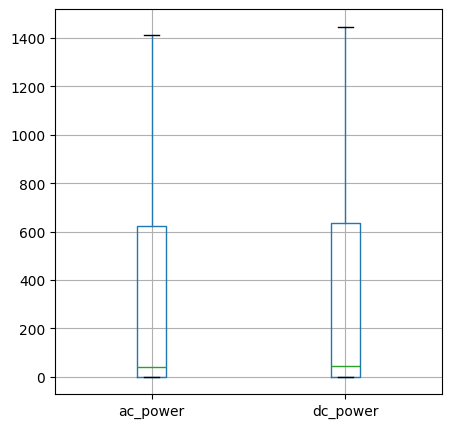

In [7]:
# Fixing scale diiference between AC_POWER and DC_POWER

prod_p1['dc_power'] = prod_p1['dc_power'].values/10
prod_p1[['ac_power', 'dc_power']].boxplot(figsize=(5,5))
plt.show()

In [8]:
def plot_source(df, supp_data, source_n, start=0, end=3400):
    df = df.copy()
    fig_size = (12,12)
    fig = plt.figure(figsize=fig_size)
    for i,item in enumerate(['ac_power','dc_power','daily_yield', 'total_yield']):
        source_data = df[df['source_key'] == source_n].iloc[start:end]
        plt.subplot(4,1,i+1)
        plt.plot(source_data['date_time'].values, source_data[item].values)
        key  = supp_data['source_key'][source_n]
        plt.title(f'{item} for Source {source_n} ({key})', fontsize=12)

    plt.tight_layout()
    return fig.axes

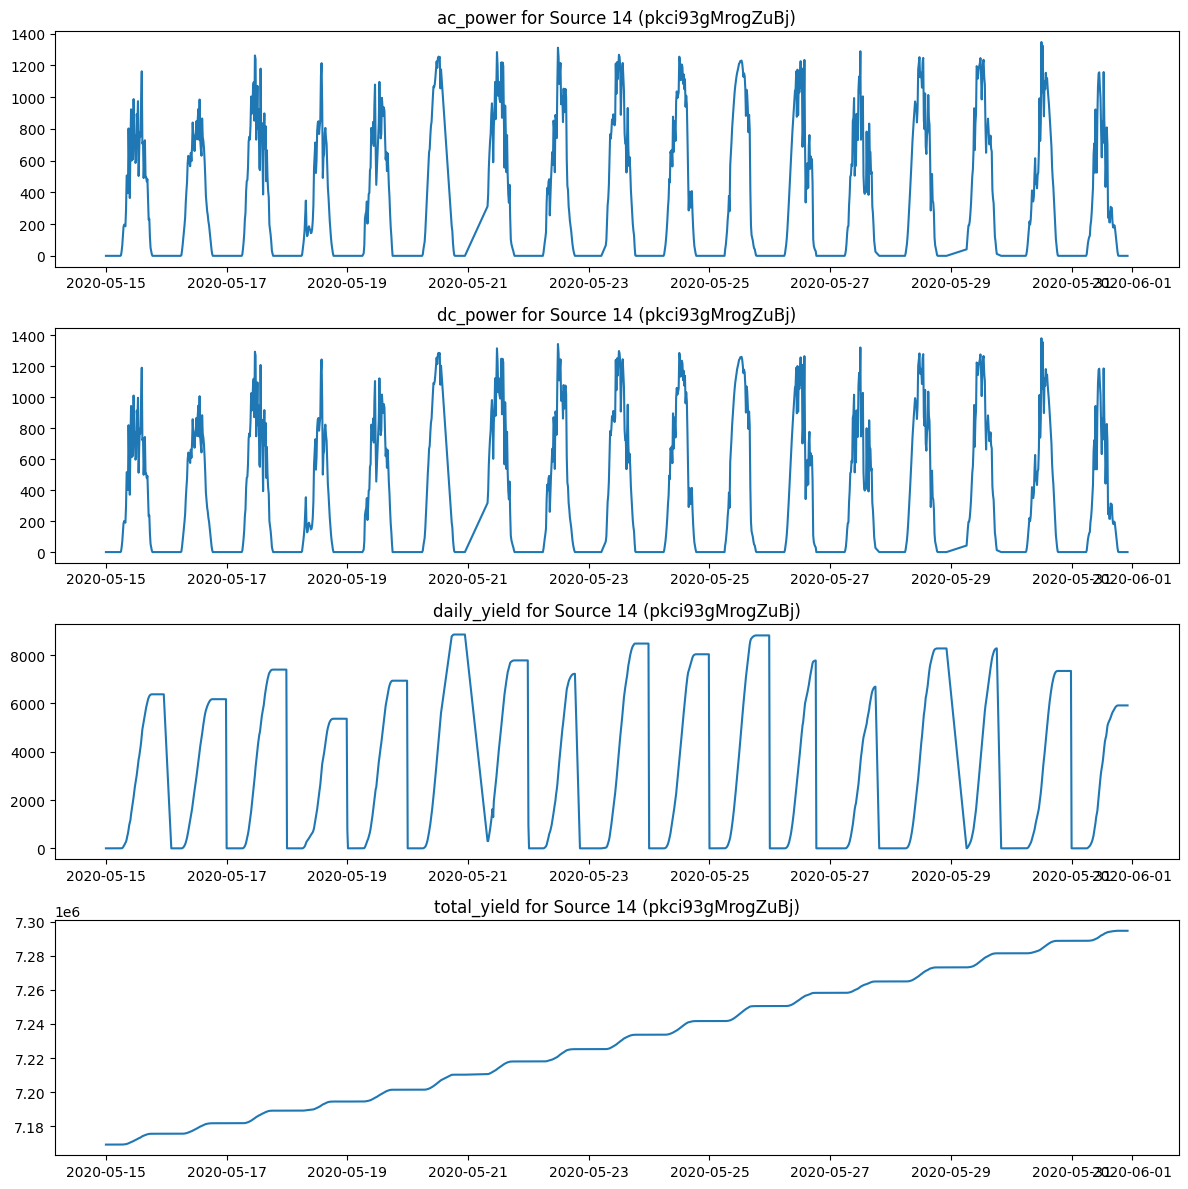

In [9]:
axes = plot_source(prod_p1, p1_deleted_data, 14, start=0, end=1500)

- The graphs have distorted waveforms in some instances. For consequence calculations made from the data could yield inaccurate results.
- Some  daily_yield instances are shorter  without the common top plateau, which indicates the data is not standardized. 
- From the distortion we can infer that some values are missing, now weh ave to find them and try to standardize.
- No safe way to input data during the day, but night is 0 (no sun)

In [10]:
import pandas as pd
import numpy as np

def find_missing(df):
    missing_data = pd.DataFrame({})
    date_time, dt_count = np.unique(df['date_time'].values, return_counts=True)
    dt_range = pd.date_range(start=date_time[0], end=date_time[-1], freq="15min")
    key = np.unique(df['source_key'].values)
    
    missing_data['date_time'] = dt_range[~np.isin(dt_range, date_time)]
    source_key = [key for _ in range(len(missing_data['date_time']))]
    missing_data['source_key'] = source_key
    
    dt_with_missing = date_time[dt_count < 22]
    df_missing = df[df['date_time'].isin(dt_with_missing)]
    
    missing_data_list = []
    for dt in dt_with_missing:
        present_key = df_missing.loc[df_missing['date_time'] == dt, 'source_key'].values
        missing_key = np.setdiff1d(key, present_key)
        missing_data_list.append({'date_time': dt, 'source_key': missing_key})
    
    missing_data = pd.concat([missing_data, pd.DataFrame(missing_data_list)], ignore_index=True)
    missing_data.sort_values(by=['date_time'], ignore_index=True, inplace=True) 
    return missing_data


def missing_summary(df, missing_data):
    present_dt = np.unique(df['date_time'].values)
    expected_dt = pd.date_range(start=present_dt[0], end=present_dt[-1], freq="15min")
    expected_dt_count = len(expected_dt)
    missing_dt = pd.DatetimeIndex(missing_data['date_time'].values)
    missing_dt_count = len(missing_dt)
    day_missing_dt_count = len(missing_dt[(missing_dt.hour >= 6) & (missing_dt.hour <= 18.5)])
    night_missing_dt_count = missing_dt_count - day_missing_dt_count

    print(f"Total expected datetimes: {expected_dt_count}")
    print(f"Total present datetimes: {len(present_dt)}\n")
    print(f"Total dt with missing entries or absent: {missing_dt_count} ({100 * missing_dt_count / expected_dt_count:.2f}%)")
    print(f"Absent dt (all sources are missing): {expected_dt_count - len(present_dt)} ({100 * (expected_dt_count - len(present_dt)) / expected_dt_count:.2f}%)")
    print(f"Present dt with some sources missing: {missing_dt_count - (expected_dt_count - len(present_dt))} ({100 * (missing_dt_count - (expected_dt_count - len(present_dt))) / expected_dt_count:.2f}%)")
    print(f"All dt with missing sources in day time: {day_missing_dt_count} ({100 * day_missing_dt_count / expected_dt_count:.2f}%)")
    print(f"All dt with missing sources in the night: {night_missing_dt_count} ({100 * night_missing_dt_count / expected_dt_count:.2f}%)")


In [11]:
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes: 3264
Total present datetimes: 3158

Total dt with missing entries or absent: 207 (6.34%)
Absent dt (all sources are missing): 106 (3.25%)
Present dt with some sources missing: 101 (3.09%)
All dt with missing sources in day time: 65 (1.99%)
All dt with missing sources in the night: 142 (4.35%)


In [12]:
def plot_missing_entries(prod_df, supp_data, missing_data):
    prod_df = prod_df.copy()
    night_ix = pd.DatetimeIndex(missing_data['date_time'].values).hour + pd.DatetimeIndex(missing_data['date_time'].values).minute/60
    night_ix = (night_ix < 6.00) | (night_ix > 18.5)
    missing_matrix = np.ones((22, len(missing_data)))
    for i, missing in enumerate(missing_data['source_key'].values):
        for j in np.unique(prod_df['source_key'].values):
            if j in missing:
                missing_matrix[j][i] = 0.3 if night_ix[i] else 0
    _, ax = plt.subplots(figsize=(len(missing_data) // 3.5, 15))

    ax.matshow(missing_matrix, aspect=2)

    keys = supp_data['source_key']
    plt.yticks(range(len(keys)), supp_data['source_key'], fontsize=12)
    plt.xticks(range(len(missing_data['date_time'])), missing_data['date_time'], rotation='vertical')
    
    plt.show()

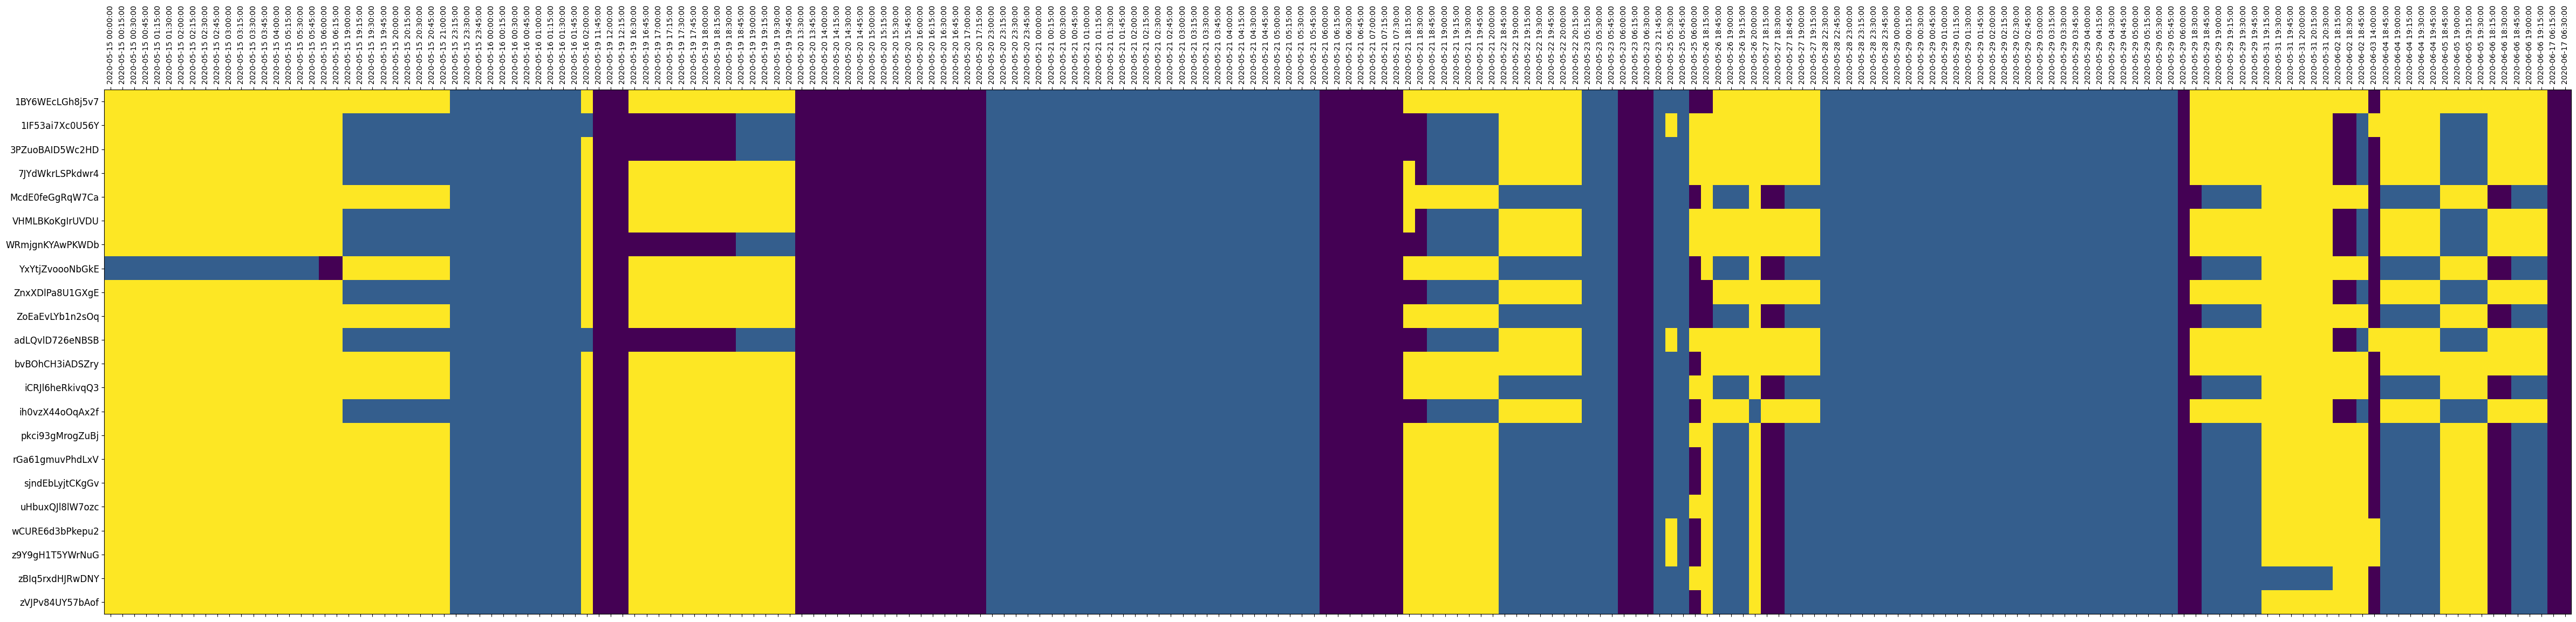

In [13]:
plot_missing_entries(prod_p1, p1_deleted_data, prod_p1_missing_data)

- The majority of missing values are at night, those can be easily imputed since there is no production at night. 
- Data missing during the day but total yeild going up may be due do malfunction

- The missing timestamps appear to be mostly simultaneous rather than in individual sources. If it is a failure then it seems to be of systemic origin.

In [14]:
def fill_night_missing(df, missing_data):
    new_entries = pd.DataFrame([], columns=df.columns)
    
    night_ix = pd.DatetimeIndex(missing_data['date_time'].values).hour + pd.DatetimeIndex(missing_data['date_time'].values).minute / 60
    night_ix = (night_ix < 6.00) | (night_ix > 18.5)
    
    night_missing = missing_data[night_ix].explode('source_key')
    
    for key in np.unique(night_missing['source_key'].values):
        key_data = df[df['source_key'] == key]
        skmnt = pd.DatetimeIndex(night_missing[night_missing['source_key'] == key]['date_time'].values)
        index = np.searchsorted(key_data['date_time'].values, skmnt)
        
        nearest_total_yield = key_data.iloc[index - 1]['total_yield']
        source_key = np.full(len(index), key, dtype=np.int8)
        zeros = np.full(len(index), 0.0, dtype=np.float32)
        total_yield = np.full(len(index), nearest_total_yield, dtype=np.float32)
        
        intermediate_df = pd.DataFrame(zip(skmnt, source_key, zeros, zeros, zeros, total_yield), columns=df.columns)
        new_entries = pd.concat([new_entries, intermediate_df], ignore_index=True)
    
    new_entries['source_key'] = np.array(new_entries['source_key'].values, np.int8)
    df = pd.concat([df, new_entries], ignore_index=True)
    df.sort_values(by=['date_time'], ascending=True, ignore_index=True, inplace=True)
    return df

def std_daily_yield(df):
    date_time = pd.DatetimeIndex(df['date_time'].values).hour + pd.DatetimeIndex(df['date_time'].values).minute / 60
    ix = np.multiply((date_time <= 18.5), (date_time >= 6))
    df['daily_yield'] = np.multiply(df['daily_yield'].values, ix)
    return df

def remove_daytime_zeros(prod_df):
    date_time = pd.DatetimeIndex(prod_df['date_time'].values).hour + pd.DatetimeIndex(prod_df['date_time'].values).minute / 60
    daytime_zeros = (date_time > 6.5) & (date_time < 18) & (prod_df['ac_power'] <= 0)
    return prod_df[~daytime_zeros]


In [15]:
prod_p1 = remove_daytime_zeros(prod_p1)
prod_p1 = fill_night_missing(prod_p1, prod_p1_missing_data)
prod_p1 = std_daily_yield(prod_p1)

In [16]:
prod_p1_missing_data = find_missing(prod_p1)
missing_summary(prod_p1, prod_p1_missing_data)

Total expected datetimes: 3264
Total present datetimes: 3232

Total dt with missing entries or absent: 84 (2.57%)
Absent dt (all sources are missing): 32 (0.98%)
Present dt with some sources missing: 52 (1.59%)
All dt with missing sources in day time: 84 (2.57%)
All dt with missing sources in the night: 0 (0.00%)


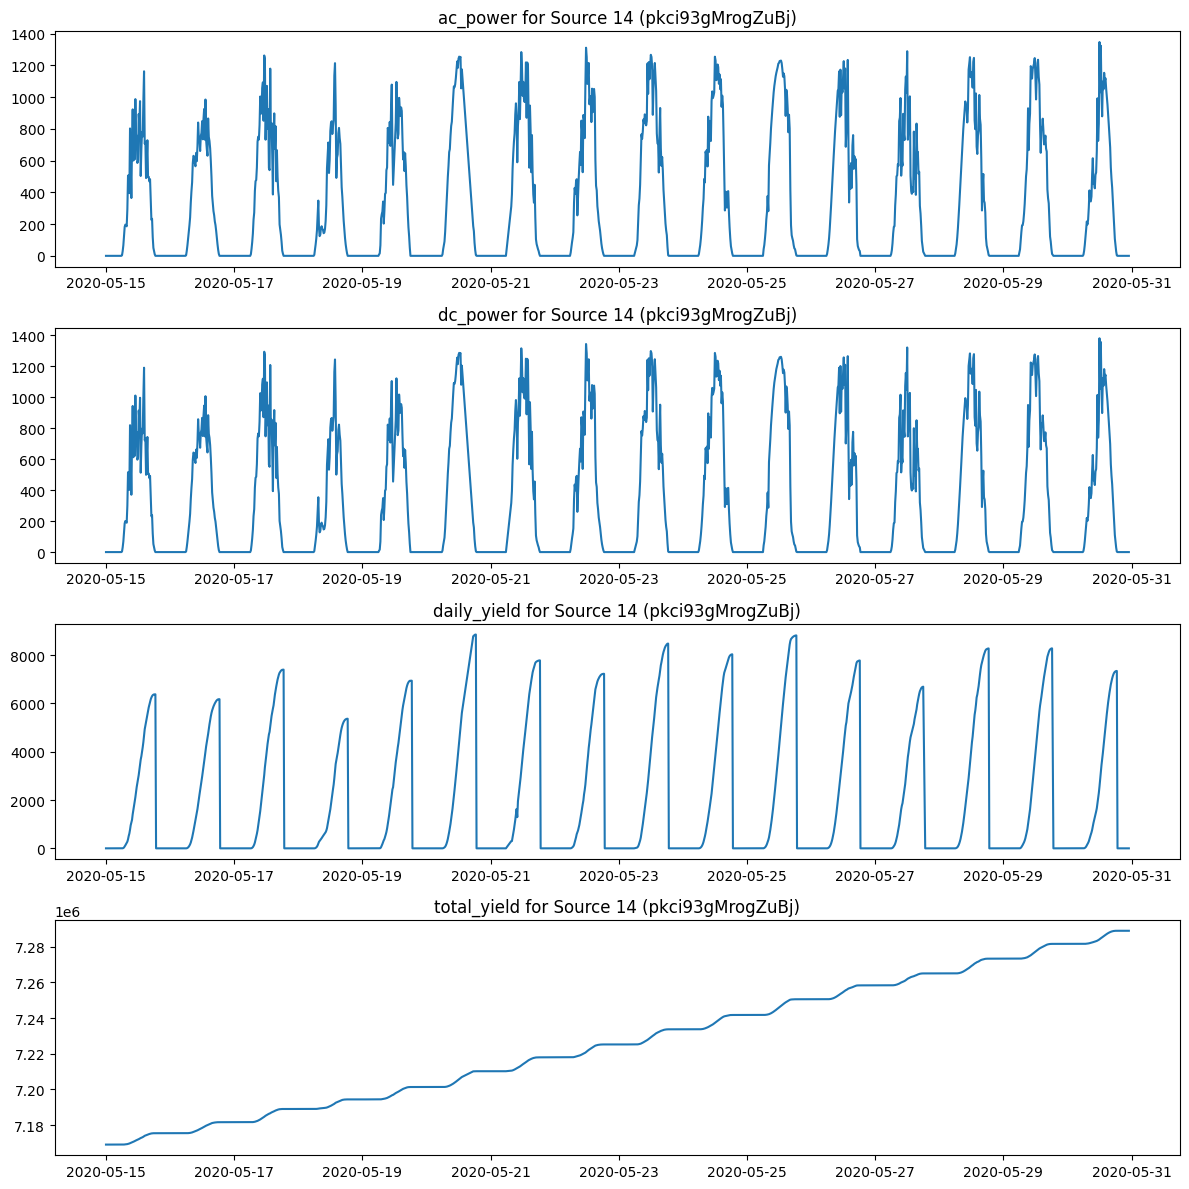

In [17]:
axes = plot_source(prod_p1, p1_deleted_data, 14, start=0, end=1500)

# Plant 1 Weather

In [18]:
p1ws.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [19]:
p1ws["SOURCE_KEY"].value_counts()

SOURCE_KEY
HmiyD2TTLFNqkNe    3182
Name: count, dtype: int64

In [20]:
def clean_ws(df):
    if "DATE_TIME" not in df.columns:
        raise ValueError("Cleaned")
    
    supp_data = {'plant_id': df['PLANT_ID'].iat[0], 'sensors': df['SOURCE_KEY'].values[0]}
    df.drop(columns=['SOURCE_KEY', 'PLANT_ID'], inplace=True)
    df.rename(columns={'DATE_TIME': 'date_time', 'AMBIENT_TEMPERATURE': 'ambient_t',
                       'MODULE_TEMPERATURE': 'module_t', 'IRRADIATION': 'irradiation'},
              inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True)

    return df, supp_data


In [21]:
p1ws, p1ws_supp_data = clean_ws(p1ws)

In [22]:
def plot_sensor(df, supp_data, start=0, end=3400,fig_size=(12,9)):
    
    df = df.copy().iloc[start:end]
    fig = plt.figure(figsize=fig_size)
    for i,item in enumerate(['ambient_t','module_t', 'irradiation']):
        plt.subplot(3,1,i+1)
        plt.plot(df['date_time'].values, df[item].values,linewidth=1.5,alpha=0.4)
        sensor  = supp_data['sensors']
        start_date= pd.to_datetime(df['date_time'].iloc[0]).date()
        end_date  = pd.to_datetime(df['date_time'].iloc[-1]).date() 
        plt.title(f'{item} for sensor {sensor} from {start_date} to {end_date}', fontsize=12)
    plt.tight_layout()
    return fig.axes

In [23]:
p1ws_supp_data['sensors'],p1ws_supp_data['plant_id']

('HmiyD2TTLFNqkNe', 4135001)

[<Axes: title={'center': 'ambient_t for sensor HmiyD2TTLFNqkNe from 2020-05-17 to 2020-05-28'}>,
 <Axes: title={'center': 'module_t for sensor HmiyD2TTLFNqkNe from 2020-05-17 to 2020-05-28'}>,
 <Axes: title={'center': 'irradiation for sensor HmiyD2TTLFNqkNe from 2020-05-17 to 2020-05-28'}>]

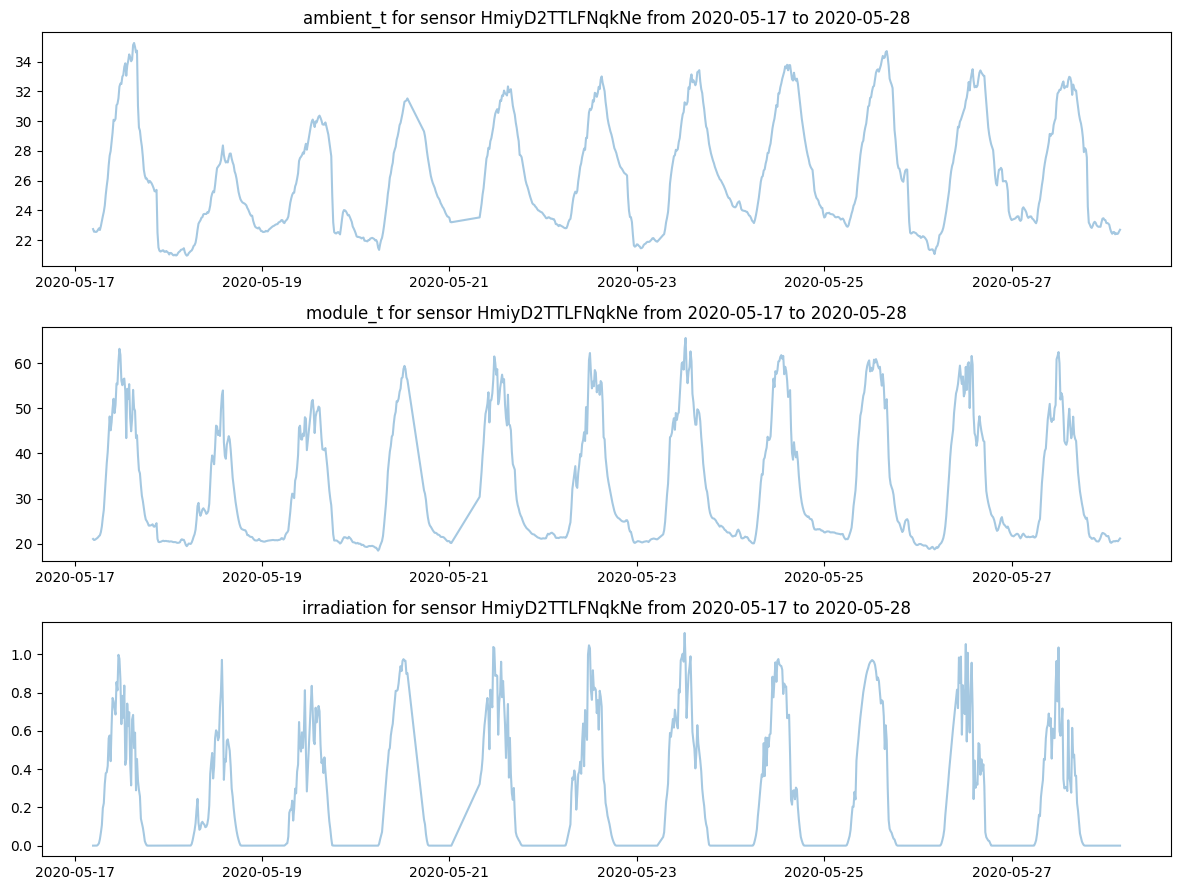

In [24]:
plot_sensor(p1ws, p1ws_supp_data, start=200, end=1200)

There seems to be missing timestamps in the sensor data as well.
They wil be left untouched

# Plant 2 production data

In [25]:
prod_p2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [26]:
prod_p2, prod_p2_supp_data = clean(prod_p2)

In [27]:
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes: 3264
Total present datetimes: 3259

Total dt with missing entries or absent: 909 (27.85%)
Absent dt (all sources are missing): 5 (0.15%)
Present dt with some sources missing: 904 (27.70%)
All dt with missing sources in day time: 493 (15.10%)
All dt with missing sources in the night: 416 (12.75%)


WAY more than plant 1, YAY

In [28]:
prod_p2 = fill_night_missing(prod_p2, prod_p2_missing_data)
prod_p2_missing_data = find_missing(prod_p2)
prod_p2 = std_daily_yield(prod_p2)
prod_p2 = remove_daytime_zeros(prod_p2)

prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes: 3264
Total present datetimes: 3248

Total dt with missing entries or absent: 858 (26.29%)
Absent dt (all sources are missing): 16 (0.49%)
Present dt with some sources missing: 842 (25.80%)
All dt with missing sources in day time: 858 (26.29%)
All dt with missing sources in the night: 0 (0.00%)


[<Axes: title={'center': 'ac_power for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'dc_power for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'daily_yield for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'total_yield for Source 10 (Qf4GUc1pJu5T6c6)'}>]

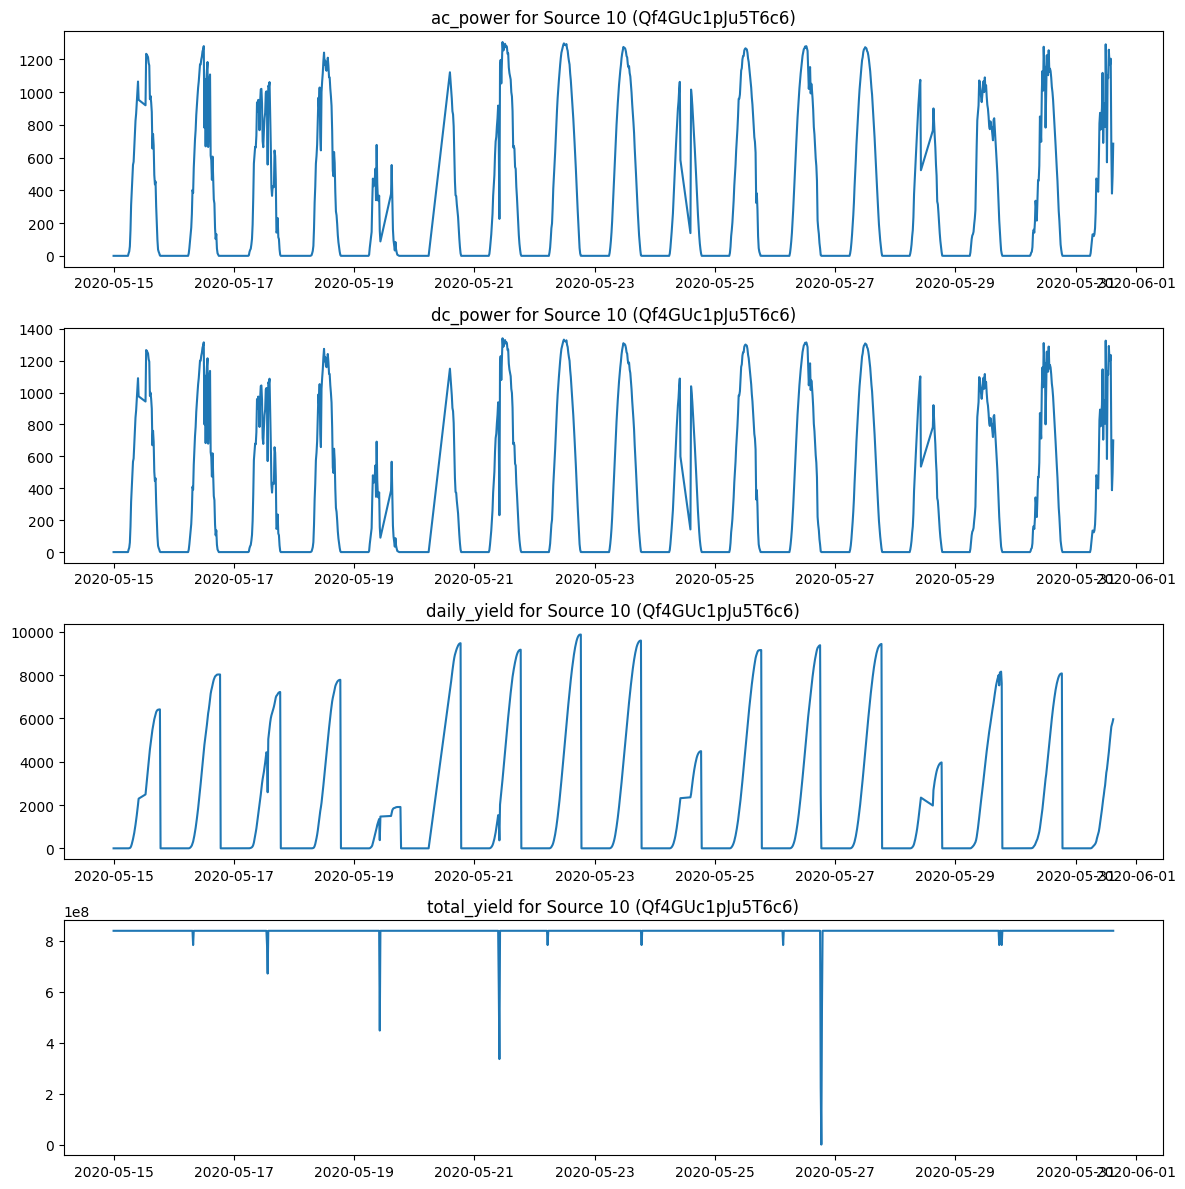

In [29]:
plot_source(prod_p2, prod_p2_supp_data, 10, start=0, end=1500)

- Better, but there is still work.
- There seem to be anomalies we have to filter out

In [30]:
def filter_total_yield_anomalies(prod_df, variable):
    new_ix = []
    for _, key_df in prod_df.groupby('source_key'):
        field = key_df[variable].values
        if variable == 'daily_yield':
            field = np.cumsum(field)
        filter_ix = (field[1:] - field[:-1]) < 0
        present_outliers = np.any(filter_ix)

        while present_outliers:
            field = key_df[variable].values
            if variable == 'daily_yield':
                field = np.cumsum(field)
            filter_ix = np.hstack([[False], (field[1:] - field[:-1]) < 0])
            key_df = key_df[filter_ix == False]
            field = key_df[variable].values
            filter_ix = np.hstack([(field[1:] - field[:-1]) < 0, [False]])
            present_outliers = np.any(filter_ix)
        new_ix.extend(key_df.index)

    new_ix.sort()
    init = len(prod_df)
    end = len(new_ix)
    print(f'Initial Dataframe Length: {init}')
    print(f'Final Dataframe length: {end}')
    print(f'Filtered out records: {init - end} ({(init - end) / init * 100:.1f}%)')
    
    return prod_df.loc[new_ix, :]

def filter_daily_yield_anomalies(prod_df):
    df = prod_df.copy()
    initial_size = len(df)
    
    def get_filter_values(sub_df):
        dt = pd.DatetimeIndex(sub_df['date_time'].values)
        daily_yield = sub_df['daily_yield'].values
        delta = np.hstack([[0], daily_yield[1:] - daily_yield[:-1]])
        periods = np.hstack([[1], (dt[1:] - dt[:-1]).seconds / 900])
        delta = delta / periods
        return (delta < 0) & (daily_yield != 0)
        
    for key, key_df in df.groupby('source_key'):
        yield_filter = get_filter_values(key_df)
        ix_to_drop = []

        while np.any(yield_filter):
            key_ix = key_df.index
            bad_ix = [key_ix[key_ix < ix][-1] for ix in key_ix[yield_filter]]
            ix_to_drop.extend(bad_ix)
            key_df = key_df.drop(bad_ix)
            yield_filter = get_filter_values(key_df)

        df.drop(ix_to_drop, inplace=True)

    reduction_percentage = (initial_size - len(df)) / initial_size * 100
    print(f"Dataset reduction: {reduction_percentage:0.2f}%")
    
    return df


In [31]:
prod_p2 = filter_total_yield_anomalies(prod_p2,'total_yield')
prod_p2 = filter_daily_yield_anomalies(prod_p2)

Initial Dataframe Length: 65739
Final Dataframe length: 64098
Filtered out records: 1641 (2.5%)
Dataset reduction: 0.72%


[<Axes: title={'center': 'ac_power for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'dc_power for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'daily_yield for Source 10 (Qf4GUc1pJu5T6c6)'}>,
 <Axes: title={'center': 'total_yield for Source 10 (Qf4GUc1pJu5T6c6)'}>]

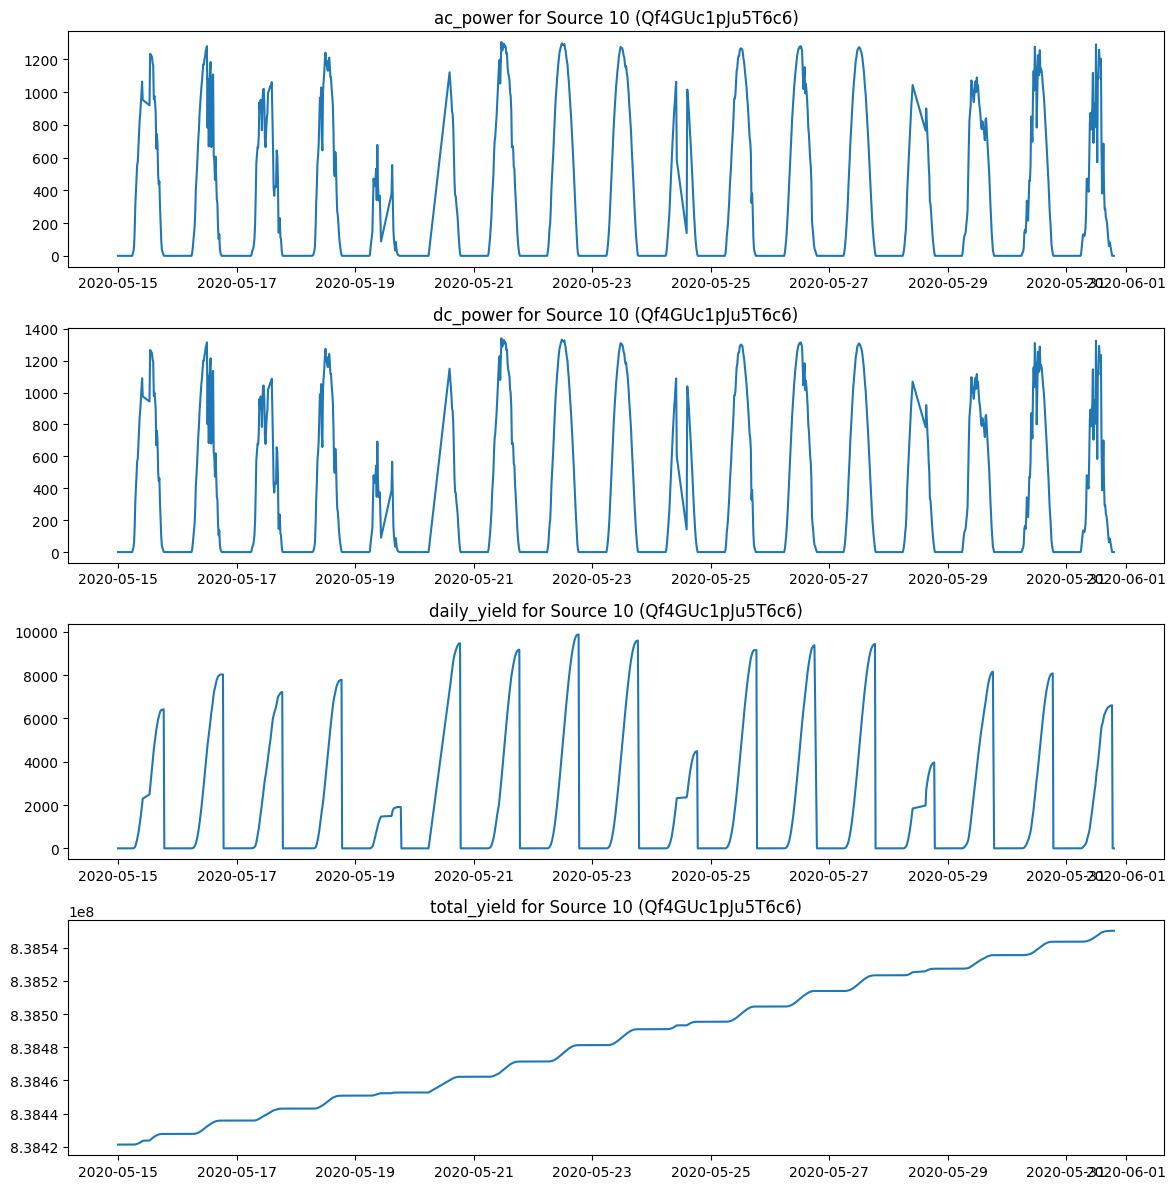

In [32]:
plot_source(prod_p2,prod_p2_supp_data, 10, start=0, end=1500)

NOICE

In [33]:
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

prod_p2 = fill_night_missing(prod_p2, prod_p2_missing_data)
prod_p2_missing_data = find_missing(prod_p2)
missing_summary(prod_p2, prod_p2_missing_data)

Total expected datetimes: 3264
Total present datetimes: 3211

Total dt with missing entries or absent: 1505 (46.11%)
Absent dt (all sources are missing): 53 (1.62%)
Present dt with some sources missing: 1452 (44.49%)
All dt with missing sources in day time: 1131 (34.65%)
All dt with missing sources in the night: 374 (11.46%)
Total expected datetimes: 3264
Total present datetimes: 3211

Total dt with missing entries or absent: 1122 (34.38%)
Absent dt (all sources are missing): 53 (1.62%)
Present dt with some sources missing: 1069 (32.75%)
All dt with missing sources in day time: 1122 (34.38%)
All dt with missing sources in the night: 0 (0.00%)


# Plant 2 Weather data

In [34]:
p2ws.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [35]:
p2ws, p2ws_supp_data = clean_ws(p2ws)

[<Axes: title={'center': 'ambient_t for sensor iq8k7ZNt4Mwm3w0 from 2020-05-17 to 2020-05-27'}>,
 <Axes: title={'center': 'module_t for sensor iq8k7ZNt4Mwm3w0 from 2020-05-17 to 2020-05-27'}>,
 <Axes: title={'center': 'irradiation for sensor iq8k7ZNt4Mwm3w0 from 2020-05-17 to 2020-05-27'}>]

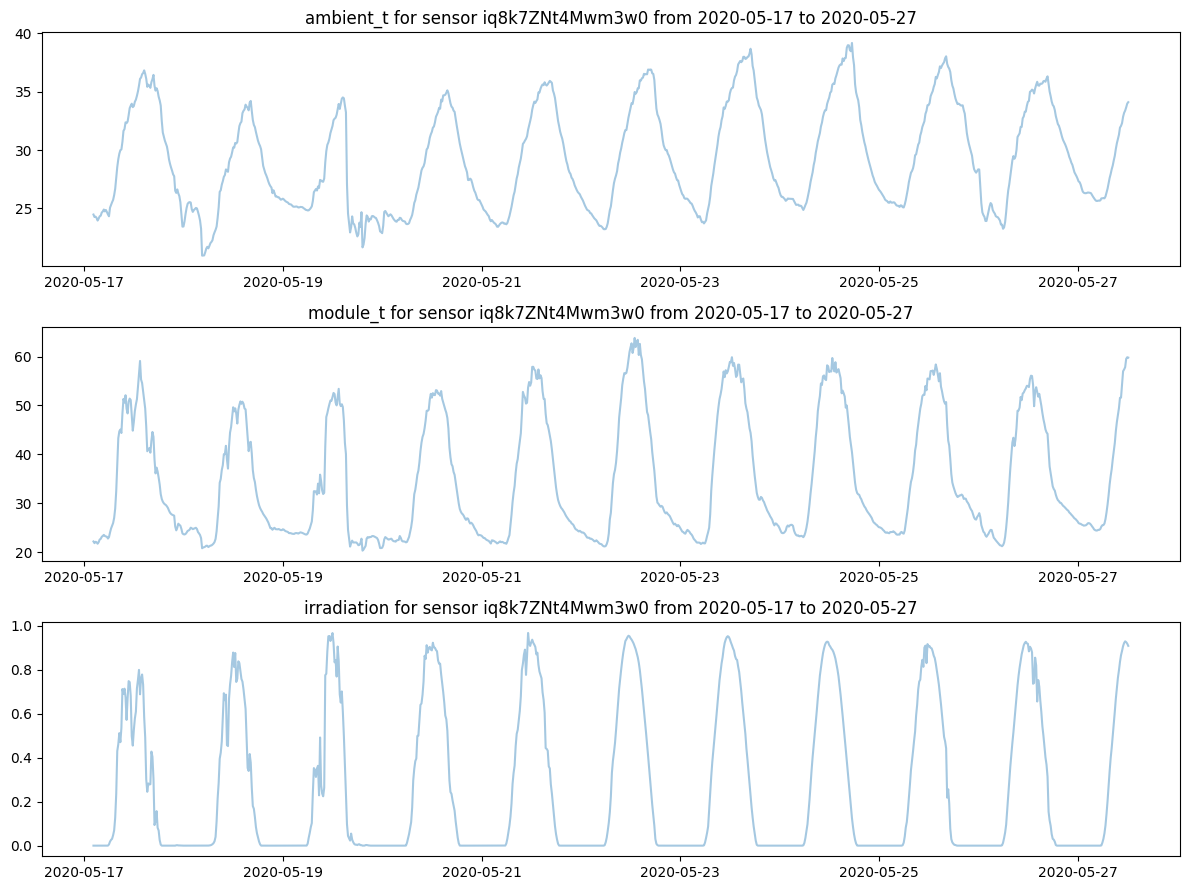

In [36]:
plot_sensor(p2ws, p2ws_supp_data, start=200, end=1200)

In [37]:
prod_p1.to_csv('prod_p1_treated.csv')
prod_p2.to_csv('prod_p2_treated.csv')
p1ws.to_csv('p1ws_treated.csv')
p2ws.to_csv('p2ws_treated.csv')

Good enough

# Modeling

### Power modeling after mathematic formula

In [38]:
def create_new_features(prod_df,sensor_df,key_n):
    df = prod_df.copy()[prod_df['source_key']==key_n]
    df = pd.merge(left=sensor_df,right=df,how='inner',on='date_time')
    hours = pd.DatetimeIndex(df['date_time'].values)
    hours = hours.hour + hours.minute/60
    df = df[(hours >= 6) & (hours <= 18.5)]
    df.rename(columns={'irradiation':'Gir','ac_power':'pac', 
                       'ambient_t': 'Ta'}, inplace=True)
    df = df[['date_time','source_key','Gir','Ta','pac']]
    df['hours'] = hours[(hours >= 6) & (hours <= 18.5)]
    df['Gir^3'] = np.power(df['Gir'],3)
    df['Gir^2'] = np.power(df['Gir'],2)
    df['Ta^2']  = np.power(df['Ta'],2)
    df['Gir^2.Ta'] = np.multiply(df['Gir^2'],df['Ta'])
    df['Gir.Ta^2'] = np.multiply(df['Gir'],df['Ta^2'])
    df['Gir.Ta'] =  np.multiply(df['Gir'],df['Ta'])
    df = df[['date_time','hours','Gir^3','Gir^2','Gir^2.Ta','Gir.Ta^2',
                     'Gir.Ta','Gir','pac']]
                     
    return df

In [39]:
prod_p1_new_data = create_new_features(prod_p1,p1ws,1)
prod_p1_new_data.head()

,date_time,hours,Gir^3,Gir^2,Gir^2.Ta,Gir.Ta^2,Gir.Ta,Gir,pac
24,2020-05-15 06:00:00,6.00,2.040199e-07,0.000035,0.000835,3.415926,0.141808,0.005887,5.162500
25,2020-05-15 06:15:00,6.25,1.106215e-05,0.000496,0.011921,12.846653,0.535018,0.022282,30.014286
26,2020-05-15 06:30:00,6.50,1.206250e-04,0.002441,0.058535,28.404842,1.184684,0.049410,69.200000
27,2020-05-15 06:45:00,6.75,8.680992e-04,0.009100,0.220395,55.954521,2.310357,0.095394,130.142857
28,2020-05-15 07:00:00,7.00,2.859687e-03,0.020147,0.494357,85.460059,3.482849,0.141940,195.100000


In [40]:
def split_data(df):
    X = df.drop(columns=['hours','pac'])
    pac = df['pac'].values
    train_size = int(0.8*len(pac))
    X_train ,  X_test  =   X.iloc[:train_size,:],   X.iloc[train_size:,:];
    pac_train, pac_test= pac[:train_size],   pac[train_size:];
    #filter out pac=0
    ix = pac_test > 0
    pac_test = pac_test[ix]
    X_test = X_test[ix]
    return X_train, X_test, pac_train, pac_test;

X_train, X_test, pac_train, pac_test = split_data(prod_p1_new_data)

In [41]:
def find_best_regressor(X_train, pac_train):
    X_train = X_train.drop(columns=['date_time']).values
    models = [
            ('LinearRegression', LinearRegression(fit_intercept =False, n_jobs=-1)),
            ('Ridge', Ridge(fit_intercept =False, solver= 'lsqr', random_state=1973)),
            ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=1973)),
            ('RandomForestRegressor', RandomForestRegressor(random_state=1973, n_jobs=-1)),
            ('KNeighborsRegressoreg', KNeighborsRegressor(n_neighbors=5,n_jobs=-1)),
            ]
    scores = dict({})
    ts_split = TimeSeriesSplit(n_splits=6)
    for name,model in models:
        folds = ts_split.split(X_train, pac_train)
        regressor = clone(model)
        cv_scores = cross_validate(regressor, X_train, pac_train,
                                   cv=folds, scoring='neg_mean_squared_error')
        scores[name.rjust(10," ")] = np.mean(cv_scores['test_score'])
    scores = pd.DataFrame(scores.items(),columns=['model','Neg_MSE'])
    scores = scores.sort_values(by=['Neg_MSE'],ascending=False,ignore_index=True)
    return scores

find_best_regressor(X_train, pac_train )

,model,Neg_MSE
0,LinearRegression,-3296.815222
1,Ridge,-3329.422660
2,RandomForestRegressor,-4070.689901
3,DecisionTreeRegressor,-6829.150383
4,KNeighborsRegressoreg,-10057.929686


Best performing model seems to be Linear Regression

In [42]:
def construct_models(prod_df,sensor_df):
    models = []
    predictions_df = pd.DataFrame({})
    rmse = []
    def get_final_model(X, X_t, pac, pac_t):
        model = LinearRegression()
        model.fit(X, pac)
        pac_pred = model.predict(X_t).flatten()
        return model, pac_pred, mean_squared_error(pac_t, pac_pred)
    
    for key in np.unique(prod_df['source_key'].values):
        new_features = create_new_features(prod_df,sensor_df,key)
        X_train, X_test, pac_train, pac_test = split_data(new_features)
        date_time = X_test['date_time'].values
        X_train = X_train.drop(columns=['date_time']).values
        X_test  = X_test.drop(columns=['date_time']).values
        model, pac_predicted, mse = get_final_model(X_train, X_test,
                                                    pac_train, pac_test)
        models += [model]
        rmse += [np.sqrt(mse)]
        r2score = int(100*r2_score(pac_test,pac_predicted))
        residuals = (pac_predicted-pac_test)
        print(f"Source {p1_deleted_data['source_key'][key]} : RMSE = {rmse[-1]:.2f} | R2 Score = {r2score}%")
        new_data = pd.DataFrame({
              'date_time':date_time,'source_key':np.full(len(residuals),key),
              'pac':pac_test, 'pac_predicted':pac_predicted,
              'residuals':residuals  }) 
        predictions_df = pd.concat([predictions_df,new_data],ignore_index=True)
    predictions_df.sort_values(by='date_time', ignore_index=True, inplace=True)
    return models, predictions_df, rmse

In [43]:
plant1_models, plant1_predictions, plant1_rmses = construct_models(prod_p1, p1ws)

Source 1BY6WEcLGh8j5v7 : RMSE = 66.72 | R2 Score = 95%
Source 1IF53ai7Xc0U56Y : RMSE = 41.70 | R2 Score = 98%
Source 3PZuoBAID5Wc2HD : RMSE = 49.21 | R2 Score = 97%
Source 7JYdWkrLSPkdwr4 : RMSE = 42.69 | R2 Score = 98%
Source McdE0feGgRqW7Ca : RMSE = 42.83 | R2 Score = 98%
Source VHMLBKoKgIrUVDU : RMSE = 46.01 | R2 Score = 98%
Source WRmjgnKYAwPKWDb : RMSE = 53.84 | R2 Score = 97%
Source YxYtjZvoooNbGkE : RMSE = 40.54 | R2 Score = 98%
Source ZnxXDlPa8U1GXgE : RMSE = 40.58 | R2 Score = 98%
Source ZoEaEvLYb1n2sOq : RMSE = 41.42 | R2 Score = 98%
Source adLQvlD726eNBSB : RMSE = 45.45 | R2 Score = 98%
Source bvBOhCH3iADSZry : RMSE = 64.61 | R2 Score = 95%
Source iCRJl6heRkivqQ3 : RMSE = 41.65 | R2 Score = 98%
Source ih0vzX44oOqAx2f : RMSE = 36.70 | R2 Score = 98%
Source pkci93gMrogZuBj : RMSE = 46.22 | R2 Score = 98%
Source rGa61gmuvPhdLxV : RMSE = 42.77 | R2 Score = 98%
Source sjndEbLyjtCKgGv : RMSE = 40.62 | R2 Score = 98%
Source uHbuxQJl8lW7ozc : RMSE = 44.28 | R2 Score = 98%
Source wCU

In [44]:
def plot_sample(predictions_df,key):
    key_df = predictions_df[predictions_df['source_key']==key]
    plt.figure(figsize=(16,3))
    plt.plot(key_df['date_time'],key_df['pac'],label='Actual AC_POWER')
    plt.plot(key_df['date_time'],key_df['pac_predicted'], label="Predicted AC_POWER")
    plt.legend(loc='best')
    plt.title(f"Predicted and actual AC_POWER for source {p1_deleted_data['source_key'][key]}")
    plt.show()

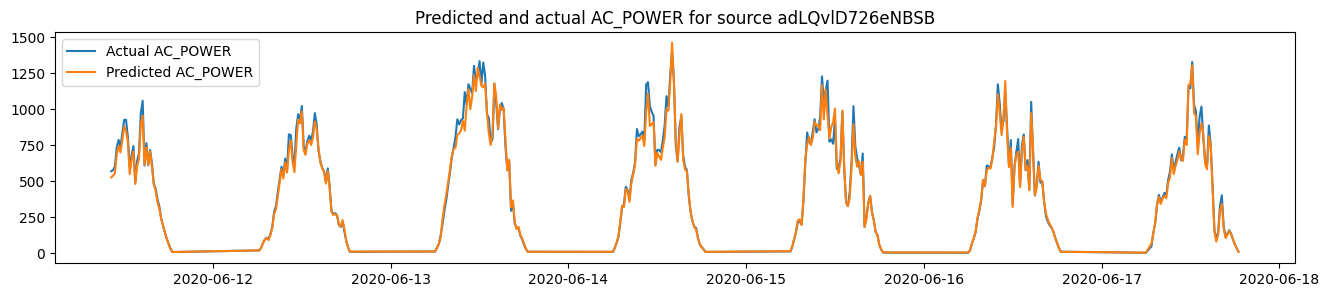

In [45]:
plot_sample(plant1_predictions, 10)

In [46]:
def get_total_yields(prod_df, prediction_df, key):
    plt.figure(figsize=(12,6))
    prod_df = prod_df[prod_df['source_key']==key]
    prediction_df = prediction_df[prediction_df['source_key']==key]
    merged_df = pd.merge(prod_df,prediction_df,on=['date_time'], how='inner')
    pac = merged_df['pac'].values
    date_time= pd.DatetimeIndex(merged_df['date_time'])
    time_delta = np.hstack([[0.25],(date_time[1:]-date_time[0:-1]).seconds/3600])
    pred_total_yield = np.hstack([[0],(pac[1:]+pac[0:-1])/2])
    pred_total_yield = np.cumsum(pred_total_yield*time_delta)
    plt.plot(date_time,pred_total_yield,label='Predicted total_yield')
    
    prod_df = prod_df[prod_df['date_time']>=date_time[0]]
    total_yield = prod_df['total_yield'].values
    total_yield = total_yield - total_yield.min()
    plt.plot(prod_df['date_time'].values, total_yield, label='Actual total_yield')

    
    daily_yield = prod_df['daily_yield'].values
    energy = np.hstack([[0],daily_yield[1:]-daily_yield[0:-1]])
    
    date_time = prod_df['date_time'].values
    date_time = date_time[energy>=0]
    energy    = energy[energy>=0]

    plt.title(f"Actual and Predicted Total Yield for source {p1_deleted_data['source_key'][key]}")
    
    plt.legend()
    plt.show()

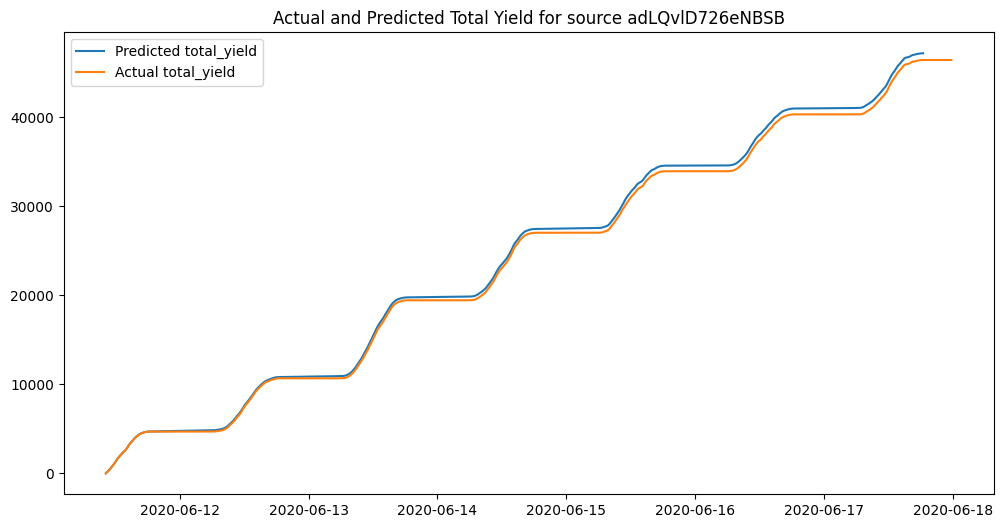

In [47]:
get_total_yields(prod_p1, plant1_predictions,10)

### Power plant 2 modelling

In [48]:
prod_p2_new_data = create_new_features(prod_p2,p2ws,1)
prod_p2_new_data.head()

,date_time,hours,Gir^3,Gir^2,Gir^2.Ta,Gir.Ta^2,Gir.Ta,Gir,pac
24,2020-05-15 06:00:00,6.00,0.000002,0.000168,0.004157,7.935394,0.320715,0.012962,14.246667
25,2020-05-15 06:15:00,6.25,0.000009,0.000443,0.010960,12.901377,0.520975,0.021038,24.353333
26,2020-05-15 06:30:00,6.50,0.000076,0.001801,0.044634,26.070688,1.051818,0.042435,53.614286
27,2020-05-15 06:45:00,6.75,0.001109,0.010711,0.268302,64.934823,2.592390,0.103496,145.606667
28,2020-05-15 07:00:00,7.00,0.007934,0.039780,1.021293,131.460472,5.120533,0.199450,286.893333


In [49]:
plant2_models, plant2_predictions, plant2_rmses = construct_models(prod_p2, p2ws)

Source 1BY6WEcLGh8j5v7 : RMSE = 127.37 | R2 Score = 78%
Source 1IF53ai7Xc0U56Y : RMSE = 58.06 | R2 Score = 96%
Source 3PZuoBAID5Wc2HD : RMSE = 56.44 | R2 Score = 96%
Source 7JYdWkrLSPkdwr4 : RMSE = 107.22 | R2 Score = 80%
Source McdE0feGgRqW7Ca : RMSE = 84.97 | R2 Score = 92%
Source VHMLBKoKgIrUVDU : RMSE = 66.10 | R2 Score = 95%
Source WRmjgnKYAwPKWDb : RMSE = 42.99 | R2 Score = 97%
Source YxYtjZvoooNbGkE : RMSE = 91.80 | R2 Score = 85%
Source ZnxXDlPa8U1GXgE : RMSE = 86.19 | R2 Score = 91%
Source ZoEaEvLYb1n2sOq : RMSE = 91.93 | R2 Score = 90%
Source adLQvlD726eNBSB : RMSE = 111.89 | R2 Score = 77%
Source bvBOhCH3iADSZry : RMSE = 106.15 | R2 Score = 76%
Source iCRJl6heRkivqQ3 : RMSE = 87.45 | R2 Score = 87%
Source ih0vzX44oOqAx2f : RMSE = 56.25 | R2 Score = 97%
Source pkci93gMrogZuBj : RMSE = 91.97 | R2 Score = 91%
Source rGa61gmuvPhdLxV : RMSE = 88.53 | R2 Score = 87%
Source sjndEbLyjtCKgGv : RMSE = 101.28 | R2 Score = 85%
Source uHbuxQJl8lW7ozc : RMSE = 64.40 | R2 Score = 95%
Sourc

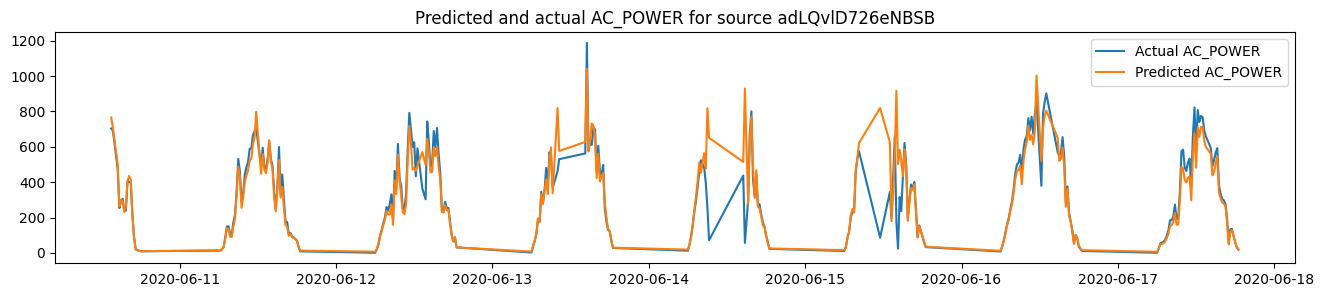

In [50]:
plot_sample(plant2_predictions, 10)

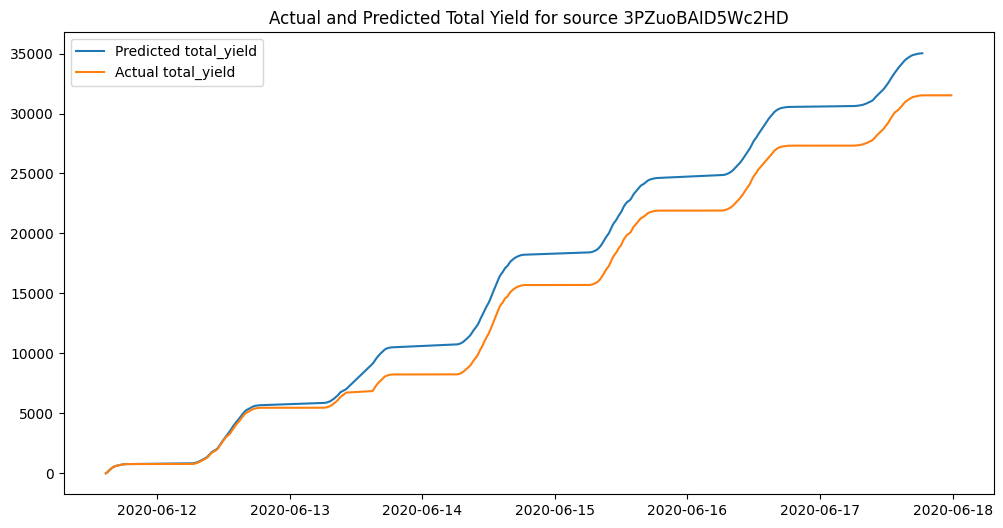

In [51]:
get_total_yields(prod_p2, plant2_predictions, 2)

### Trying to detect anomalies (maintenance prediction)

In [52]:
def plot_avg_power_irradiance_ratio(prod_df, sensor_df):
    plt.figure(figsize=(14,4))
    key_df = pd.merge(left=sensor_df,right=prod_df,how='inner',
                      on='date_time')
    key_df = key_df[key_df['irradiation']>0]
    key_df['ratio']=key_df['ac_power']/key_df['irradiation']
    key_df = key_df.groupby(['source_key'], as_index=False).mean()
    key_df.sort_values(by='ratio',ascending=False,inplace=True)
    color_range = key_df['ratio']-key_df['ratio'].min()*1.02
    color_range = color_range/color_range.max()
    bar_colors = plt.cm.coolwarm_r(color_range)
    bars = plt.bar(key_df['source_key'].values.astype(np.str_),
            key_df['ratio'], color = bar_colors)
    plt.yticks(ticks=[])
    max_height = key_df['ratio'].values.max()
    plt.ylim([0,max_height*1.1])
    
    for b in bars:
        height = b.get_height()
        plt.annotate(f'{int(height)}',xy=(b.get_x()-b.get_width()/2,height),
                     xytext=(12,6), textcoords='offset points',fontsize=10)
        plt.annotate(f'{int(100*(height/max_height-1))}%',
                     xy=(b.get_x()-b.get_width()/2,max_height*2/3),
                     xytext=(15,0),textcoords='offset points',
                     backgroundcolor='w',fontsize=9)
    plt.xlabel("Sources")
    plt.ylabel("Power / Irradiation")
    plt.title("power / irradiance ratio by source")
    plt.xticks(range(len(np.unique(prod_df['source_key'].values))))
    plt.show()

Irradiance is the most important feature in our context

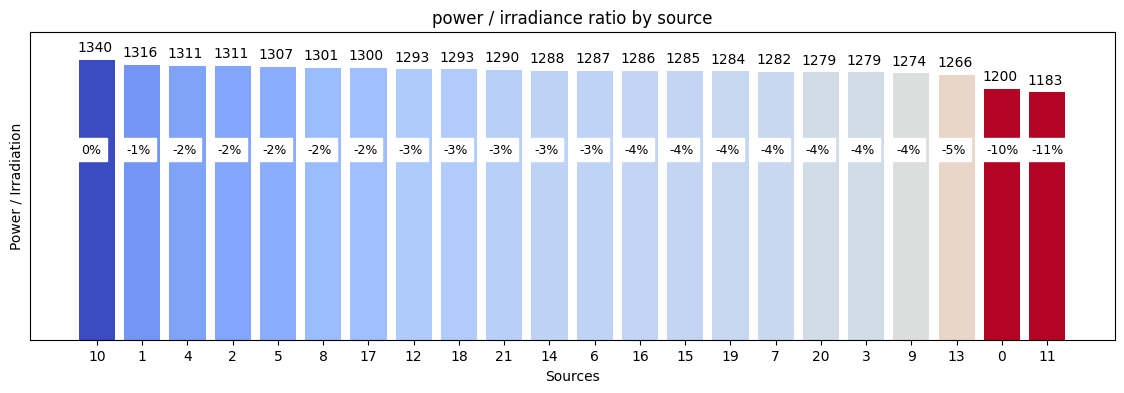

In [53]:
plot_avg_power_irradiance_ratio(prod_p1, p1ws)

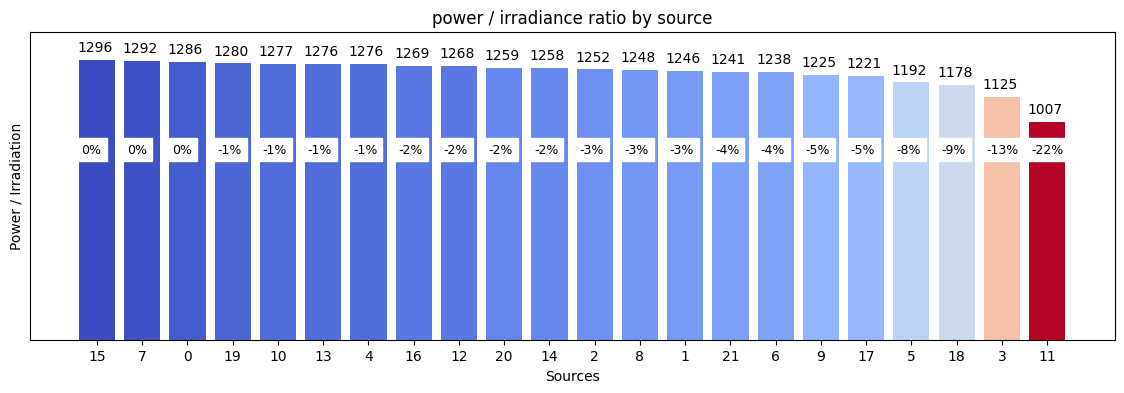

In [54]:
plot_avg_power_irradiance_ratio(prod_p2, p2ws)

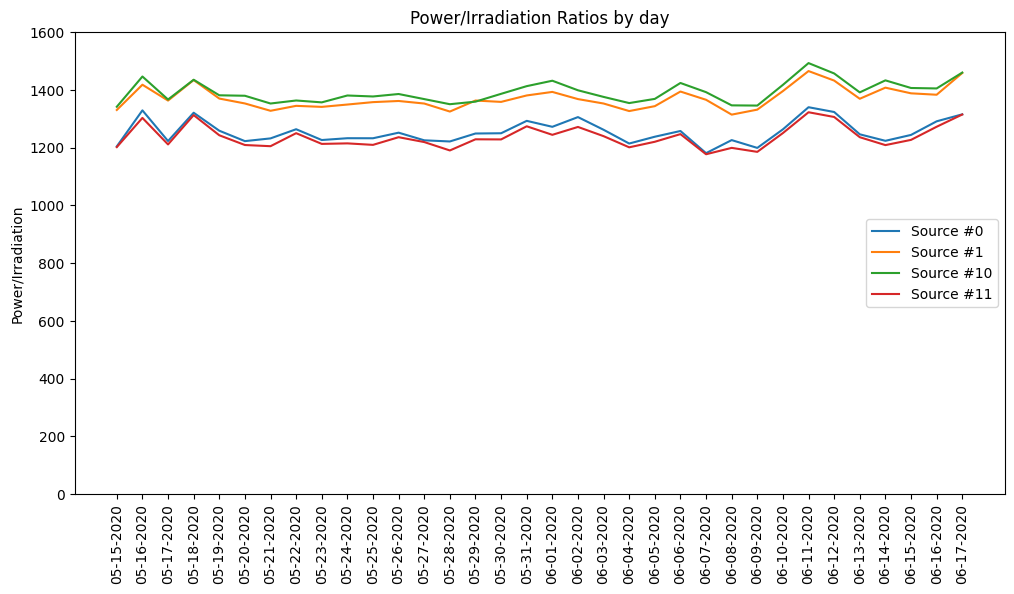

In [55]:
def plot_power_irr_ratio(prod_df, sensor_df, keys):
    plt.figure(figsize=(12,6))
    for i,key in enumerate(keys):
        key_df = prod_df[prod_df['source_key']==key]
        key_df = pd.merge(key_df,sensor_df, how='inner',on='date_time')
        key_df = key_df[key_df['irradiation']>0]
        key_df['ratio']  = key_df['ac_power']/key_df[ 'irradiation']
        key_df = key_df[key_df['ratio'] > 0]
        key_df['date_time'] = pd.DatetimeIndex(key_df['date_time']).strftime("%m-%d-%Y")
        key_df = key_df.groupby(by='date_time',as_index=False).mean()
        plt.plot(key_df['date_time'],key_df['ratio'],label=f'Source #{key}' )
        ax = plt.gca()
    ax.set_title("Power/Irradiation Ratios by day")
    ax.set_ylabel("Power/Irradiation")
    ax.legend(loc='center right')
    ax.set_ylim((0,1600))
    plt.xticks(key_df['date_time'],rotation=90)
    
plot_power_irr_ratio(prod_p1,p1ws,[0,1,10,11])

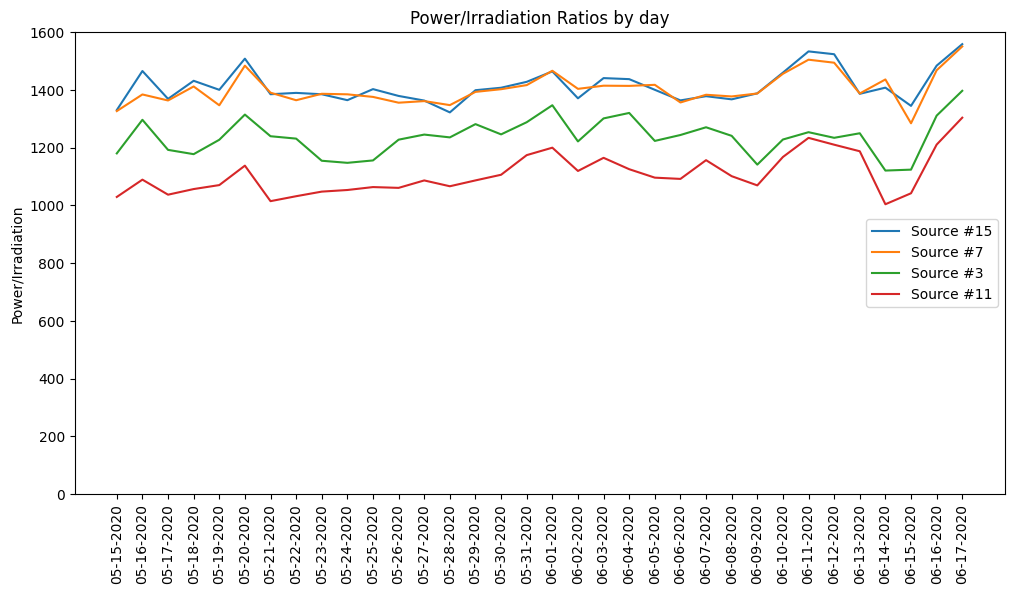

In [56]:
plot_power_irr_ratio(prod_p2,p2ws,[15, 7, 3, 11])

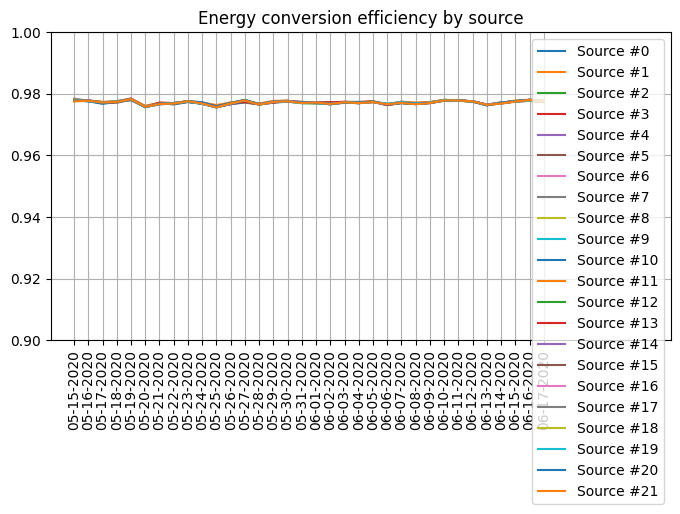

In [57]:
def plot_energy_convertsion_efficiency(prod_df):
    plt.figure(figsize=(8,4))
    for key in np.unique(prod_df['source_key'].values):
        key_df = prod_df[prod_df['source_key'] == key]
        key_df = key_df[key_df['dc_power']>0]
        key_df['date_time' ] = pd.DatetimeIndex(key_df['date_time']).strftime("%m-%d-%Y")
        key_df['efficiency'] = key_df['ac_power']/key_df['dc_power']
        key_df = key_df[(key_df['efficiency'] < 1) & (key_df['efficiency']  > 0.9)]
        key_df = key_df.groupby(by='date_time',as_index=False).mean()
        plt.plot(key_df['date_time'],key_df['efficiency'],label=f"Source #{key}")
    plt.xticks(key_df['date_time'],rotation=90)
    plt.title("Energy conversion efficiency by source")
    plt.ylim((0.9,1.))
    xmin,xmax = plt.gca().get_xlim()
    plt.xlim([xmin,xmax+(xmax-xmin)*0.2])
    plt.grid()
    plt.legend(loc='best')
plot_energy_convertsion_efficiency(prod_p1)

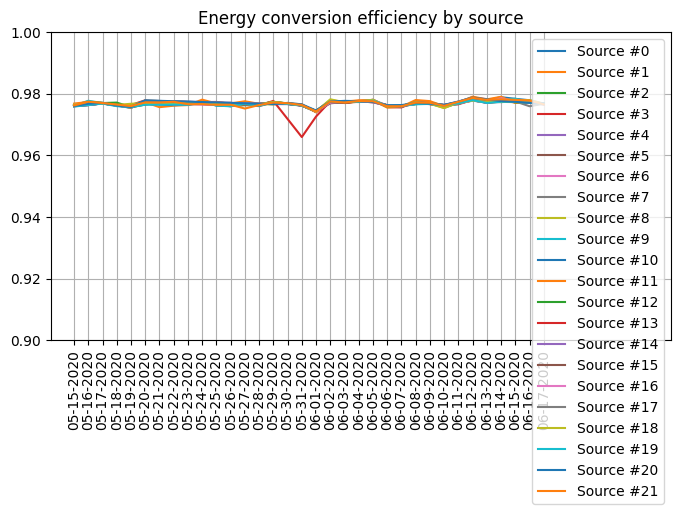

In [58]:
plot_energy_convertsion_efficiency(prod_p2)

5/31 may be an iverted problem, but can also be a data issue

### Lack of data to try and classify into working and needing maintenance